## Set up

In [1]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df = pd.read_csv('/content/drive/MyDrive/Matches.csv')

<ipython-input-9-023dd57a6ff7>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Matches.csv')


In [3]:
elo = pd.read_csv('/content/drive/MyDrive/EloRatings.csv')

In [8]:
# Merge Elo ratings for HomeTeam
df = df.merge(
    elo,
    left_on=['MatchDate', 'HomeTeam'],
    right_on=['date', 'club'],
    how='left',
    suffixes=('', '_Home')
).rename(columns={'elo': 'HomeTeamElo'})
# Merge Elo ratings for AwayTeam
df = df.merge(
    elo,
    left_on=['MatchDate', 'AwayTeam'],
    right_on=['date', 'club'],
    how='left',
    suffixes=('', '_Away')
).rename(columns={'elo': 'AwayTeamElo'})
# View the updated DataFrame
df.head()

,Division,MatchDate,MatchTime,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,...,country_Away,AwayTeamElo,date_Home,club_Home,country_Home,HomeTeamElo,date_Away,club_Away,country_Away,AwayTeamElo
0,F1,2000-07-28,NaN,Marseille,Troyes,1691.36,1581.55,0.0,0.0,0,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,F1,2000-07-28,NaN,Paris SG,Strasbourg,1720.51,1636.89,0.0,0.0,0,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,F2,2000-07-28,NaN,Wasquehal,Nancy,1458.77,1640.12,0.0,0.0,0,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,F2,2000-07-29,NaN,Ajaccio,Le Mans,1476.65,1472.12,0.0,0.0,0,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,F2,2000-07-29,NaN,Beauvais,Montpellier,1414.12,1614.09,0.0,0.0,0,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN


In [12]:
df.to_csv("/content/drive/MyDrive/cleaned_data.csv")

## Cleaning and Updating

In [10]:
# Drops the rows that we do not care to look at
df = df.drop(columns=['OddHome', 'OddDraw', 'OddAway', 'MaxHome', 'MaxDraw', 'MaxAway', 'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 'HandiSize', 'HandiHome', 'HandiAway'])

In [11]:
df['MatchDate'] = pd.to_datetime(df['MatchDate'])

In [7]:
elo['date'] = pd.to_datetime(elo['date'])

## My Analysis

### Basic Look Into Elo Ratings

In [ ]:
# If positive then the home team is better
# If negative then the away team is better
df['EloDiff'] = df['HomeElo'] - df['AwayElo']

In [ ]:
df = df.dropna(subset=['EloDiff']).copy()

df['EloDifference'] = df['EloDiff'].astype(int)

In [ ]:
df[df['HomeElo'] > 2000].value_counts().sum()

7

<Axes: xlabel='AwayElo', ylabel='AwayTarget'>

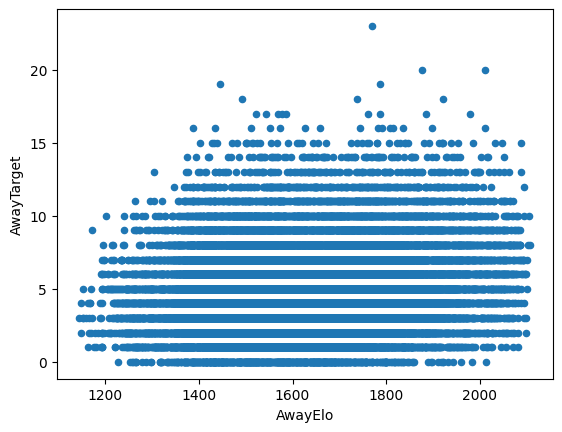

In [ ]:
df[df['EloDifference'] < 0].plot.scatter(x='AwayElo', y='AwayTarget')

In [ ]:
team_home_elo_avg = df.groupby('club')['AwayElo'].mean().sort_values(ascending=False)

# Determine the thresholds for the 1st (bottom 25%) and 4th (top 25%) quartiles
q1_threshold = team_home_elo_avg.quantile(0.25)
q4_threshold = team_home_elo_avg.quantile(0.75)

# Get teams in the bottom 25% of HomeElo rankings
bottom_25_percent_teams = team_home_elo_avg[team_home_elo_avg <= q1_threshold]

# Get teams in the top 25% of HomeElo rankings
top_25_percent_teams = team_home_elo_avg[team_home_elo_avg >= q4_threshold]

# Extract team names
bottom_25_team_names = bottom_25_percent_teams.index.tolist()
top_25_team_names = top_25_percent_teams.index.tolist()

# Filter the original DataFrame for these teams
bottom_25_df = df[df['club'].isin(bottom_25_team_names)]
top_25_df = df[df['club'].isin(top_25_team_names)]

min_rows = min(len(bottom_25_df), len(top_25_df))

# Sample randomly from each group to make them equal in size
min_rows = min(len(bottom_25_df), len(top_25_df))

# Slice the data to match row counts for both datasets
bottom_25_df = bottom_25_df.head(min_rows)
top_25_df = top_25_df.head(min_rows)

### Team Form

#### Home Form Graphs

In [ ]:
df[df['HomeElo'] > 2000]['Form3Home'].mean()

7.234119782214156

In [ ]:
df[df['HomeElo'] < 1225]['Form3Home'].mean()

3.1503649635036495

Text(0.5, 0, 'ELO Category')

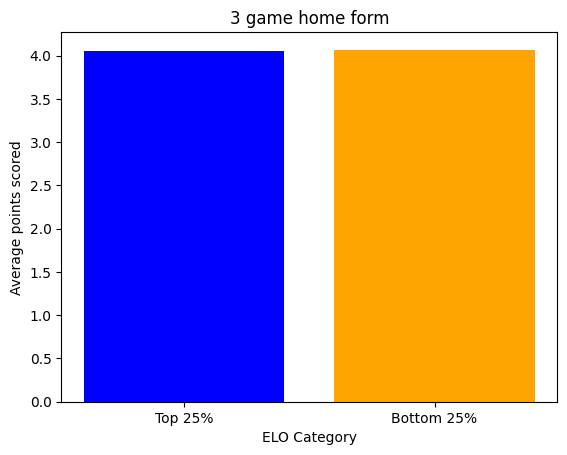

In [ ]:
low_elo_avg = bottom_25_df['Form3Home'].mean()
high_elo_avg = top_25_df['Form3Home'].mean()

# Create a bar chart to compare the two averages
elo_categories = ['Top 25%', 'Bottom 25%']
form3_home_averages = [high_elo_avg, low_elo_avg]

plt.bar(elo_categories, form3_home_averages, color=['blue', 'orange'])

# Add titles and labels
plt.title('3 game home form', fontsize=12)
plt.ylabel('Average points scored', fontsize=10)
plt.xlabel('ELO Category', fontsize=10)

Text(0.5, 0, 'ELO Category')

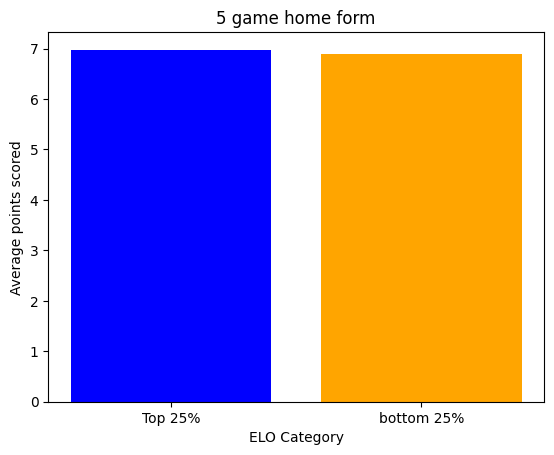

In [ ]:
low_elo_avg = bottom_25_df['Form5Home'].mean()
high_elo_avg = top_25_df['Form5Home'].mean()

# Create a bar chart to compare the two averages
elo_categories = ['Top 25%', 'bottom 25%']
form3_home_averages = [high_elo_avg, low_elo_avg]

plt.bar(elo_categories, form3_home_averages, color=['blue', 'orange'])

# Add titles and labels
plt.title('5 game home form', fontsize=12)
plt.ylabel('Average points scored', fontsize=10)
plt.xlabel('ELO Category', fontsize=10)

#### Away Form Graphs

In [ ]:
import matplotlib.ticker as mticker

Text(0.5, 0, 'ELO Category')

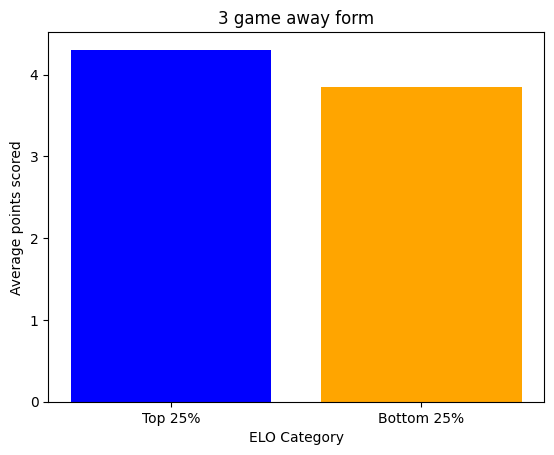

In [ ]:
low_elo_avg = bottom_25_df['Form3Away'].mean()
high_elo_avg = top_25_df['Form3Away'].mean()

elo_categories = ['Top 25%', 'Bottom 25%' ]
form3_home_averages = [high_elo_avg, low_elo_avg]

plt.bar(elo_categories, form3_home_averages, color=['blue', 'orange'])

plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.title('3 game away form', fontsize=12)
plt.ylabel('Average points scored', fontsize=10)
plt.xlabel('ELO Category', fontsize=10)

Text(0.5, 0, 'ELO Category')

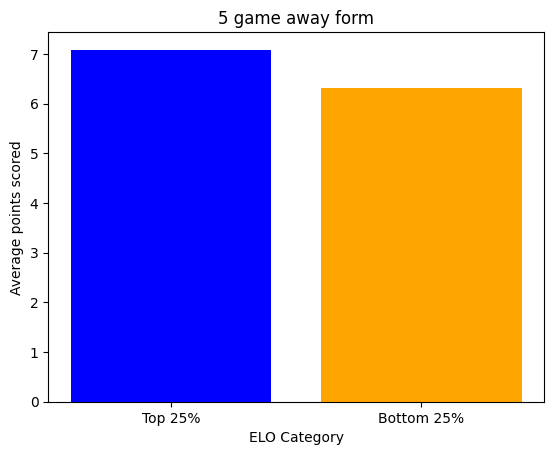

In [ ]:
low_elo_avg = bottom_25_df['Form5Away'].mean()
high_elo_avg = top_25_df['Form5Away'].mean()

elo_categories = ['Top 25%', 'Bottom 25%']
form3_home_averages = [high_elo_avg, low_elo_avg]

plt.bar(elo_categories, form3_home_averages, color=['blue', 'orange'])

plt.title('5 game away form', fontsize=12)
plt.ylabel('Average points scored', fontsize=10)
plt.xlabel('ELO Category', fontsize=10)

### Shots and Corner Stats

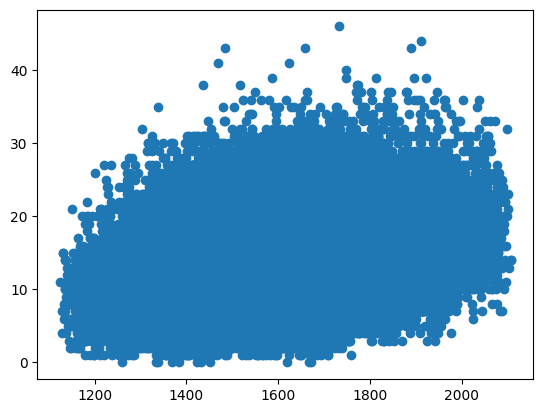

In [ ]:
plt.scatter(df['HomeElo'], df['HomeShots'])

<Axes: >

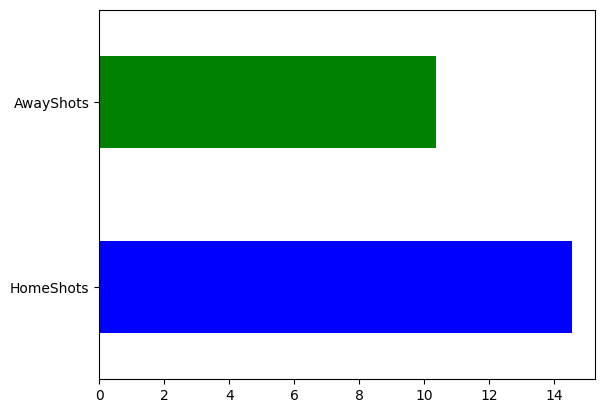

In [ ]:
average_high_shots = filtered_high[['HomeShots', 'AwayShots']].mean()
average_high_shots.plot(kind='barh', color=['blue', 'green'])

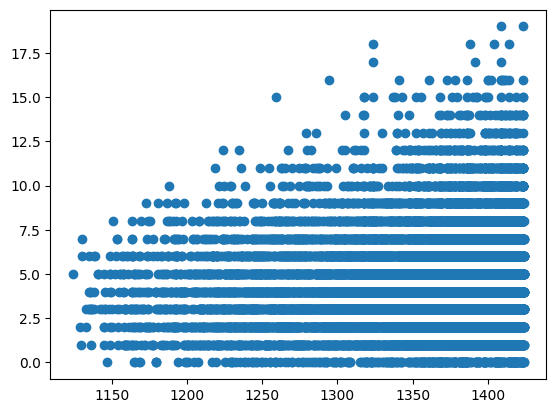

In [ ]:
threshold = df['HomeElo'].quantile(0.25)

filtered_low = df[df['HomeElo'] <= threshold]
plt.scatter(filtered_low['HomeElo'], filtered_low['HomeTarget'])

<Axes: >

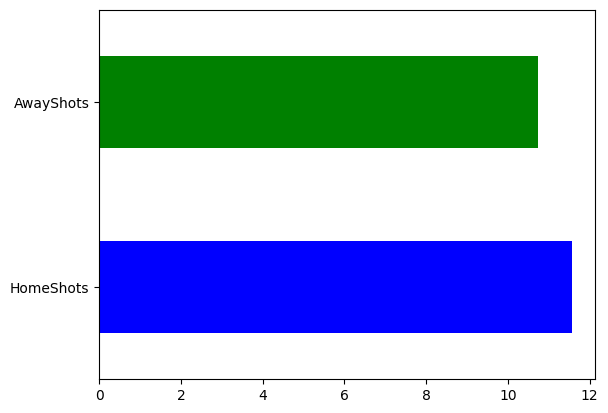

In [ ]:
average_low_shots = filtered_low[['HomeShots', 'AwayShots']].mean()
average_low_shots.plot(kind='barh', color=['blue', 'green'])

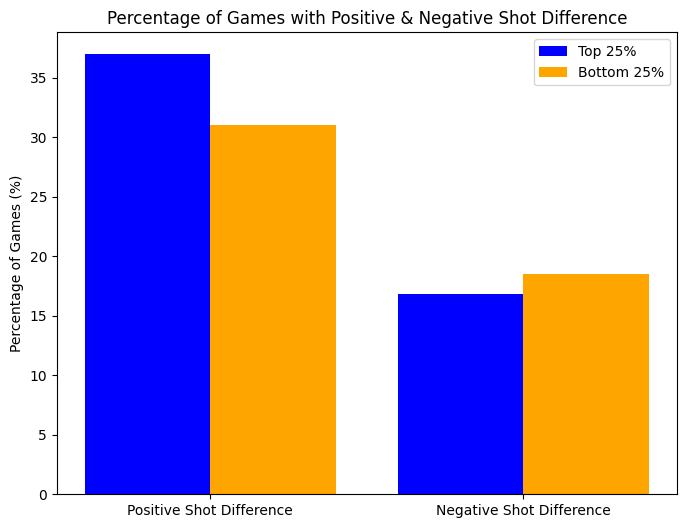

In [ ]:
import seaborn as sns

shot_diff_percentages = {
    "Top 25% Teams": {"Positive Shot Difference": 36.97, "Negative Shot Difference": 16.82},
    "Bottom 25% Teams": {"Positive Shot Difference": 31.05, "Negative Shot Difference": 18.48}
}

categories = ["Positive Shot Difference", "Negative Shot Difference"]
top_elo_values = [shot_diff_percentages["Top 25% Teams"]["Positive Shot Difference"], shot_diff_percentages["Top 25% Teams"]["Negative Shot Difference"]]
bottom_elo_values = [shot_diff_percentages["Bottom 25% Teams"]["Positive Shot Difference"], shot_diff_percentages["Bottom 25% Teams"]["Negative Shot Difference"]]

plt.figure(figsize=(8, 6))
x = range(len(categories))
plt.bar(x, top_elo_values, width=0.4, label="Top 25%", color='blue', alpha=1)
plt.bar([p + 0.4 for p in x], bottom_elo_values, width=0.4, label="Bottom 25%", color='orange', alpha=1)

plt.xticks([p + 0.2 for p in x], categories)
plt.ylabel("Percentage of Games (%)")
plt.title("Percentage of Games with Positive & Negative Shot Difference")
plt.legend()
plt.show()

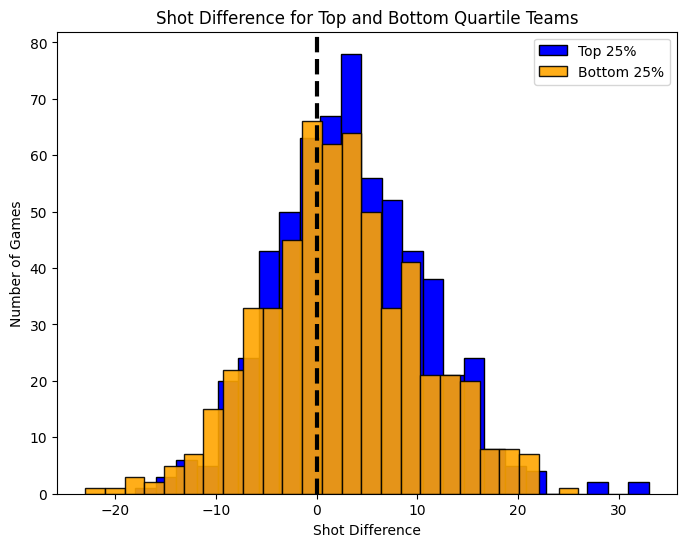

In [ ]:
# Important shot difference histogram
bottom_25_df['shot_diff'] = bottom_25_df['HomeShots'] - bottom_25_df['AwayShots']
top_25_df['shot_diff'] = top_25_df['HomeShots'] - top_25_df['AwayShots']

plt.figure(figsize=(8, 6))

plt.hist(top_25_df['shot_diff'], bins=25, alpha=1, color='blue', edgecolor='black', label='Top 25%')
plt.hist(bottom_25_df['shot_diff'], bins=25, alpha=.9, color='orange', edgecolor='black', label='Bottom 25%')

plt.axvline(x=0, color='black', linestyle='--', linewidth=3)
plt.title('Shot Difference for Top and Bottom Quartile Teams')
plt.xlabel('Shot Difference')
plt.ylabel('Number of Games')

plt.legend()

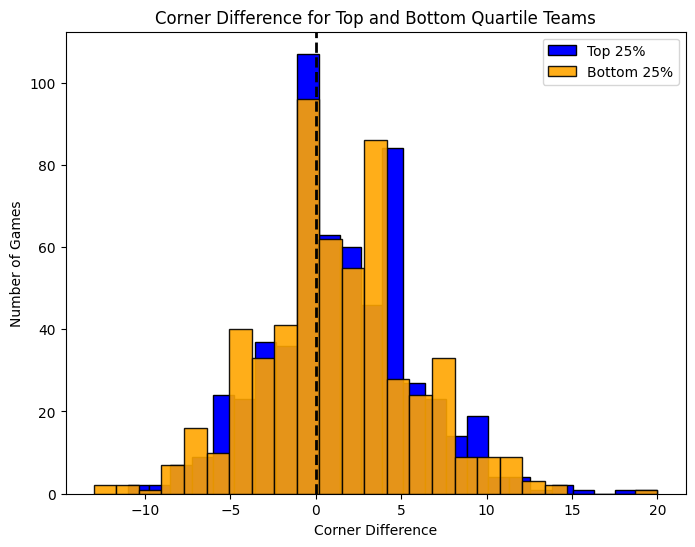

In [ ]:
# Important corner difference histogram
bottom_25_df['corner_diff'] = bottom_25_df['HomeCorners'] - bottom_25_df['AwayCorners']
top_25_df['corner_diff'] = top_25_df['HomeCorners'] - top_25_df['AwayCorners']

plt.figure(figsize=(8, 6))

plt.hist(top_25_df['corner_diff'], bins=25, alpha=1, color='blue', edgecolor='black', label='Top 25%')
plt.hist(bottom_25_df['corner_diff'], bins=25, alpha=.9, color='orange', edgecolor='black', label='Bottom 25%')


plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
plt.title('Corner Difference for Top and Bottom Quartile Teams')
plt.xlabel('Corner Difference')
plt.ylabel('Number of Games')

plt.legend()

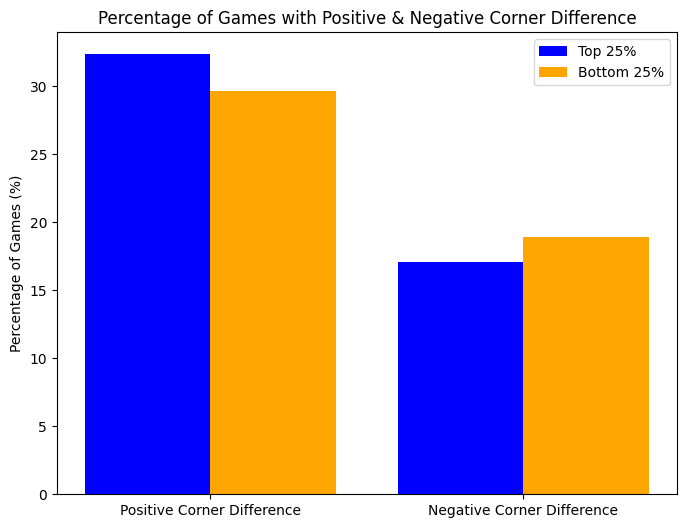

In [ ]:
corner_diff_percentages = {
    "Top 25% Teams": {"Positive Corner Difference": 32.35, "Negative Corner Difference": 17.10},
    "Bottom 25% Teams": {"Positive Corner Difference": 29.67, "Negative Corner Difference": 18.95}
}

# Extracting data for plotting
categories = ["Positive Corner Difference", "Negative Corner Difference"]
top_elo_values = [corner_diff_percentages["Top 25% Teams"]["Positive Corner Difference"], corner_diff_percentages["Top 25% Teams"]["Negative Corner Difference"]]
bottom_elo_values = [corner_diff_percentages["Bottom 25% Teams"]["Positive Corner Difference"], corner_diff_percentages["Bottom 25% Teams"]["Negative Corner Difference"]]

# Creating the bar chart for corner difference percentages
plt.figure(figsize=(8, 6))
x = range(len(categories))
plt.bar(x, top_elo_values, width=0.4, label="Top 25%", color='blue', alpha=1)
plt.bar([p + 0.4 for p in x], bottom_elo_values, width=0.4, label="Bottom 25%", color='orange', alpha=1)

plt.xticks([p + 0.2 for p in x], categories)
plt.ylabel("Percentage of Games (%)")
plt.title("Percentage of Games with Positive & Negative Corner Difference")
plt.legend()
plt.show()

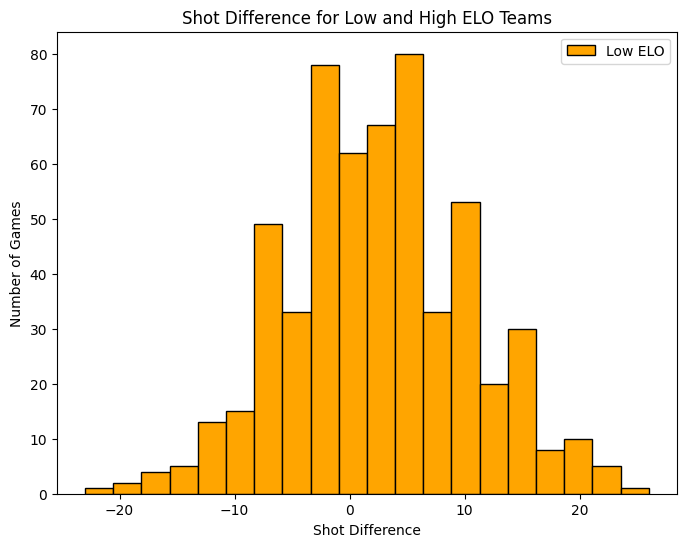

In [ ]:
bottom_25_df['shot_diff'] = bottom_25_df['HomeShots'] - bottom_25_df['AwayShots']

plt.figure(figsize=(8, 6))

plt.hist(bottom_25_df['shot_diff'], bins=20, alpha=1, color='orange', edgecolor='black', label='Low ELO')

plt.title('Shot Difference for Low and High ELO Teams')
plt.xlabel('Shot Difference')
plt.ylabel('Number of Games')

plt.legend()

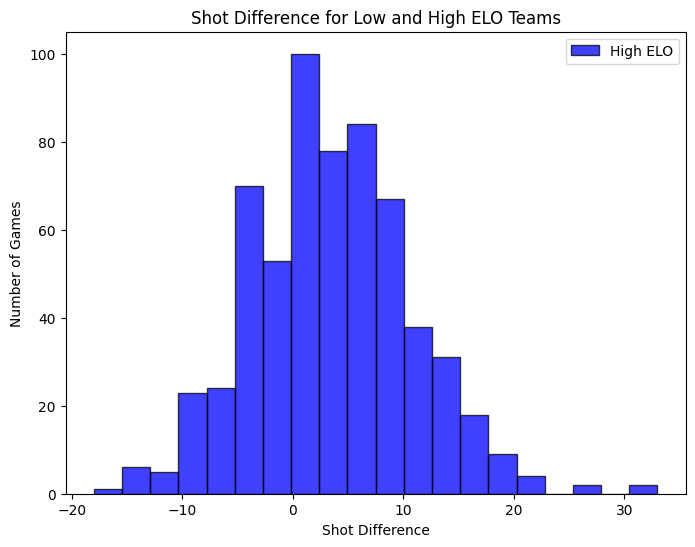

In [ ]:
top_25_df['shot_diff'] = top_25_df['HomeShots'] - top_25_df['AwayShots']

plt.figure(figsize=(8, 6))

plt.hist(top_25_df['shot_diff'], bins=20, alpha=0.75, color='blue', edgecolor='black', label='High ELO')

plt.title('Shot Difference for Low and High ELO Teams')
plt.xlabel('Shot Difference')
plt.ylabel('Number of Games')

plt.legend()

In [ ]:
positive_shot_diff = filtered_high[filtered_high['shot_diff'] < 0]
positive_shot_diff['HomeElo'].mean()

KeyError: 'shot_diff'

In [ ]:
df['ResultNum'] = df['FTResult'].map({'H': 1, 'D': 0, 'A': -1})

### Fouls and Disciplinary Records

In [ ]:
avg_fouls = df.groupby('ResultNum')[['HomeFouls', 'AwayFouls']].mean()
avg_fouls.plot(kind='barh', figsize=(8, 6), color=['blue', 'orange'])

In [ ]:
df['RedCardCategory'] = pd.cut(df['HomeRed'] + df['AwayRed'], bins=[-1, 0, 1, 2, np.inf], labels=['0', '1', '2', '3+'])
df['YellowCardCategory'] = pd.cut(df['HomeYellow'] + df['AwayYellow'], bins=[-1, 0, 2, 4, np.inf], labels=['0', '1-2', '3-4', '5+'])

avg_points_red = df.groupby('RedCardCategory')['ResultNum'].mean()
avg_points_red.plot(kind='bar', color='red')
plt.title('Average Points Earned by Total Red Cards', fontsize=14)
plt.xlabel('Total Red Cards', fontsize=12)
plt.ylabel('Average Points', fontsize=12)
plt.show()

avg_points_yellow = df.groupby('YellowCardCategory')['ResultNum'].mean()
avg_points_yellow.plot(kind='bar', color='yellow')
plt.title('Average Points Earned by Total Yellow Cards', fontsize=14)
plt.xlabel('Total Yellow Cards', fontsize=12)
plt.ylabel('Average Points', fontsize=12)
plt.show()